<a href="https://colab.research.google.com/github/jpoCruz/topicosIV/blob/main/topicos4_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nota: todo esse trabalho foi baseado no dataset disponível em https://github.com/ksb2043/instagram_influencer_dataset.


---


# Leitura do .txt inicial com a lista de influenciadores

**O código a seguir pega o .txt e limpa ele, retornando no final um .csv com a lista de seed users, organizados pelo número de seguidores.**

In [2]:
import pandas as pd

#função que lê o arquivo .txt e retorna um dataframe
def read_influencers(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [line.strip().split('\t') for line in lines[2:]]
    return pd.DataFrame(data, columns=['Username', 'Category', '#Followers', '#Followees', '#Posts'])

file_path = 'influencers.txt'
influencers = read_influencers(file_path)

# Filtra os influenciadores
fashion_influencers = influencers[influencers['Category'] == 'fashion']
fashion_influencers = fashion_influencers.drop('Category', axis=1) #não preciso mais da categoria, já que todos são de fashion
fashion_influencers = fashion_influencers.rename(columns={'#Followers': 'Followers', '#Followees': 'Followees', '#Posts': 'Posts'}) #limpa os nomes das categorias

#converte em inteiros as categorias numéricas
fashion_influencers['Followers'] = fashion_influencers['Followers'].astype(int)
fashion_influencers['Followees'] = fashion_influencers['Followees'].astype(int)
fashion_influencers['Posts'] = fashion_influencers['Posts'].astype(int)

#organiza pelo número de seguidores
fashion_influencers = fashion_influencers.sort_values(by='Followers', ascending=False)
fashion_influencers = fashion_influencers.reset_index(drop=True)

#define a lista de seed users que serão usados para a pesquisa
seed_users = ['barrefaeli',
              'bran.wolf',
              'domlever',
              'emmeline_glam',
              'jasmine_tosh',
              'kofixcase',
              'majamalnar',
              'mrjunho3',
              'ms_kuan',
              'nina.ali',
              'sarawears',
              'thehala']

#filtra o dataframe e só pega as informações sobre os seed users
fashion_seed_influencers = fashion_influencers[fashion_influencers['Username'].isin(seed_users)]
fashion_seed_influencers = fashion_seed_influencers.reset_index(drop=True)

#salva a lista filtrada e a original em um csv
fashion_influencers.to_csv('fashion_influencers.csv')
fashion_seed_influencers.to_csv('fashion_seed_influencers.csv')

#mostra a lista
fashion_seed_influencers


,Username,Followers,Followees,Posts
0,barrefaeli,2730605,597,2682
1,thehala,1748048,156,1443
2,domlever,732615,400,665
3,jasmine_tosh,709913,702,2848
4,bran.wolf,647801,615,757
5,majamalnar,436730,1052,3590
6,sarawears,366001,2389,3463
7,mrjunho3,233159,77,746
8,emmeline_glam,221742,476,1839
9,ms_kuan,204414,557,1372


# Limpeza dos arquivos do dataset

Nessa etapa, cada .json sobre post é limpo, são feitas as análises de sentimento e todas as informações são salvas em um novo .json com as informações estruturadas e claras.

In [ ]:
import os
import json
import glob
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# é feito o download do vader
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def clean_json(json_data):

    # cria a lista onde serão inseridas as seções, para depois inserir tudo no json limpo de saída
    cleaned_data = {}

    # busca as informações do usuário dono do post na lista da etapa anterior
    user_info = fashion_seed_influencers[fashion_seed_influencers['Username'] == json_data['owner']['username']]

    # cria a seção "owner" no json limpo de saída
    owner = {
        'username': json_data['owner']['username'],
        'full_name': json_data['owner']['full_name'],
        'is_verified': json_data['owner']['is_verified'],
        'id': json_data['owner']['id'],
        'followers': int(user_info['Followers'].values[0]),
        'followees': int(user_info['Followees'].values[0]),
        'total_posts': int(user_info['Posts'].values[0])

    }
    # insere na lista
    cleaned_data['owner'] = owner

    # cria a lista de usuários marcados no post e preenche ela
    tagged_users = []
    tagged_user_edges = json_data.get('edge_media_to_tagged_user', {}).get('edges', [])
    for edge in tagged_user_edges:
        tagged_user = edge.get('node', {}).get('user', {})
        if tagged_user:
            tagged_users.append(tagged_user)

    # conta quantos usuários foram marcados no post
    tagged_users_count = len(tagged_users)

    # se existirem comentários, conta e guarda cada um
    comment_count = 0
    try:
      comment_count = json_data['edge_media_to_parent_comment']['count']
    except:
      print("Number of comments not available")

    # guarda o valor da caption e faz uma análise de sentimento nela
    caption = json_data['edge_media_to_caption']['edges'][0]['node']['text']
    caption_sentiment = sia.polarity_scores(caption)

    # categoriza o sentimento entre os 5 possíveis
    compound_score = caption_sentiment['compound']
    if compound_score <= -0.5:
        caption_sentiment_res = "highly_negative"
    elif compound_score > -0.5 and compound_score < -0.1:
        caption_sentiment_res = "negative"
    elif compound_score >= -0.1 and compound_score <= 0.1:
        caption_sentiment_res = "neutral"
    elif compound_score > 0.1 and compound_score < 0.5:
        caption_sentiment_res = "positive"
    elif compound_score >= 0.5:
        caption_sentiment_res = "highly_positive"

    # calcula o número de interações (likes + comentários)
    total_interactions = (json_data['edge_media_preview_like']['count'] + comment_count)

    # cria a seção de informações sobre o post no json limpo de saída
    post_info = {
        'id': json_data.get('id'),
        'dimensions': json_data.get('dimensions', {}),
        'total_interactions' : total_interactions,
        'engagement_rate' : ((total_interactions/int(user_info['Followers'].values[0]) ) * 100), #calcula a taxa de engajamento
        'like_count': json_data['edge_media_preview_like']['count'],
        'caption': caption,
        'caption_sentiment': caption_sentiment_res,
        'caption_tags': caption.count("@"),
        'caption_hashtags': caption.count("#"),
        'caption_length': len(caption),
        'comment_count': comment_count,
        'is_ad': json_data.get('is_ad'),
        'tagged_users': tagged_users,
        'tagged_users_count': tagged_users_count,
        'location': json_data.get('location')
    }
    # insere na lista
    cleaned_data['post_info'] = post_info
    
    #cria a lista de comentários
    comments = []
    comment_edges = json_data.get('edge_media_to_parent_comment', {}).get('edges', [])
    for edge in comment_edges:
        comment = edge.get('node', {}).get('text')
        if comment:
            # exclue todos os comentários que não estão em inglês (mas mantém comentários que são só emojis)
            if not re.search(r'^[\u0000-\u007F\u2600-\u27BF]+$', comment):
                continue
            comments.append(comment)
    cleaned_data['comments'] = comments

    # analisa os sentimentos de cada comentário
    sentiment_scores = []
    for comment in comments:
      # analisa o sentimento
      sentiment = sia.polarity_scores(comment)
      sentiment_scores.append(sentiment)

    highly_negative = 0
    negative = 0
    neutral = 0
    positive = 0
    highly_positive = 0
    
    # categoriza o sentimento de cada comentário entre os 5 possíveis
    for score in sentiment_scores:
        compound_score = score['compound']
        
        if compound_score <= -0.5:
            highly_negative += 1
        elif compound_score > -0.5 and compound_score < -0.1:
            negative += 1
        elif compound_score >= -0.1 and compound_score <= 0.1:
            neutral += 1
        elif compound_score > 0.1 and compound_score < 0.5:
            positive += 1
        elif compound_score >= 0.5:
            highly_positive += 1

    # cria a seção de score dos comentários 
    comments_scores = {
        'highly_negative': highly_negative,
        'negative': negative,
        'neutral': neutral,
        'positive': positive,
        'highly_positive': highly_positive
    }
    
    # insere no arquivo final
    cleaned_data['comments_scores'] = comments_scores
    
    # retorna tudo para inserção no arquivo final
    return cleaned_data

def clean_json_files(input_dir, output_dir):

    # cria o diretório de output se ele não existir
    os.makedirs(output_dir, exist_ok=True)
    
    # pega a lista de arquivos .info do diretório de entrada
    input_files = glob.glob(os.path.join(input_dir, '*.info'))
    
    for input_file in input_files:
        # lê os arquivos como texto
        with open(input_file, 'r') as file:
            file_contents = file.read()
        
        # converte os dados dos arquivos em um objeto do python
        json_data = json.loads(file_contents)
        
        # limpa os dados
        cleaned_data = clean_json(json_data)
        
        # gera o caminhho de output
        output_file = os.path.join(output_dir, os.path.splitext(os.path.basename(input_file))[0] + '.json')
        
        # escreve o json limpo no diretório de saída
        with open(output_file, 'w') as file:
            json.dump(cleaned_data, file, ensure_ascii=False, indent=4)
        
        print(f'Cleaned JSON file saved: {output_file}')

# define os diretórios de entrada e saída dos dados
input_directory = '/content/input_directory'
output_directory = '/content/output_directory'

# limpa os jsons
clean_json_files(input_directory, output_directory)

Caso você deseja salvar os .json limpos localmente, é preciso zipar eles e fazer o download do .zip

In [ ]:
!zip -r /content/cleaned_data.zip /content/output_directory

from google.colab import files
files.download("/content/cleaned_data.zip")

# Análise dos dados limpos

Finalmente agora, com os .json limpos que nos interessam prontos para serem usados, podemos começar a analisar os dados. Esse primeiro bloco de código salva os arquivos em um dataframe.

In [8]:
import os
import json
import pandas as pd

# lê os arquivos json
directory = "/content/output_directory"
json_files = [file for file in os.listdir(directory) if file.endswith(".json")]

# cria um array vazio para guardar dataframes (cada arquivo vai ser um dataframe por um tempo)
dfs = []

# itera pelos jsons e extrai os dados
for file in json_files:
    with open(os.path.join(directory, file)) as json_file:
        data = json.load(json_file)

        # pega os dados desejados de cada .json e cria um dataframe
        row = {
            "username": data["owner"]["username"],
            "followers": data["owner"]["followers"],
            "followees": data["owner"]["followees"],
            "total_posts": data["owner"]["total_posts"],
            "post_id": data["post_info"]["id"],
            "width": data["post_info"]["dimensions"]["width"],
            "height": data["post_info"]["dimensions"]["height"],
            "total_interactions": data["post_info"]["total_interactions"],
            "engagement_rate": data["post_info"]["engagement_rate"],
            "like_count": data["post_info"]["like_count"],
            "tagged_users_count": data["post_info"]["tagged_users_count"],
            "caption_sentiment": data["post_info"]["caption_sentiment"],
            "caption": data["post_info"]["caption"],
            "caption_tags": data["post_info"]["caption_tags"],
            "caption_hashtags": data["post_info"]["caption_hashtags"],
            "caption_length": data["post_info"]["caption_length"],
            "comment_count": data["post_info"]["comment_count"],
            "is_ad": data["post_info"]["is_ad"],
            "comment_scores": data["comments_scores"]
        }
        df = pd.DataFrame([row])  # cria um dataframe a partir da linha
        dfs.append(df)  # coloca esse dataframe na lista

# concatena todos os dataframes de linha em um único e ordena por seguidores
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(by="followers", ascending=False)
df = df.reset_index(drop=True)
df

,username,followers,followees,total_posts,post_id,width,height,total_interactions,engagement_rate,like_count,tagged_users_count,caption_sentiment,caption,caption_tags,caption_hashtags,caption_length,comment_count,is_ad,comment_scores
0,barrefaeli,2730605,597,2682,1777003712969937604,1080,1080,34566,1.265873,34411,1,positive,Better late than never. \nHAPPY BIRTHDAY to TH...,1,0,78,155,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."
1,barrefaeli,2730605,597,2682,1870439143319260566,1080,1080,68716,2.516512,68110,0,negative,This is me in the middle of a work day. Swear....,0,0,61,606,False,"{'highly_negative': 1, 'negative': 0, 'neutral..."
2,barrefaeli,2730605,597,2682,1978581867554011079,1080,1329,33280,1.218778,32913,1,neutral,💋,0,0,1,367,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."
3,barrefaeli,2730605,597,2682,1753763155439002776,1080,1350,50293,1.841826,49993,0,neutral,@hoodiesil vibes 🍷♥️💋,1,0,21,300,False,"{'highly_negative': 0, 'negative': 1, 'neutral..."
4,barrefaeli,2730605,597,2682,1932863614382576383,1080,1080,29264,1.071704,28915,1,highly_positive,Thank you @lancomeofficial for my beautiful ma...,1,2,91,349,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."
5,barrefaeli,2730605,597,2682,1845664025011376203,1080,1080,23229,0.850691,23090,0,neutral,@hoodiesil winter collection 🖤,1,0,30,139,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."
6,thehala,1748048,156,1443,2003717112980632351,1080,956,25703,1.470383,25233,3,positive,I feel weird if I pose normally 🤷🏽‍♀️👼🏼 Thank ...,1,0,87,470,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."
7,thehala,1748048,156,1443,2000170244480716280,1080,1080,30629,1.752183,30037,3,positive,Feeling this blue on set with @cliniquearabia 💙,1,0,47,592,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."
8,thehala,1748048,156,1443,1860237328094860167,1080,1080,28016,1.602702,27583,1,neutral,Finally😍!! @LauraMercier ’s iconic setting pow...,1,1,224,433,False,"{'highly_negative': 2, 'negative': 0, 'neutral..."
9,thehala,1748048,156,1443,1842160312376568491,1080,1350,45986,2.630706,45986,2,neutral,Who watched my insta-stories at the @lauramerc...,1,0,157,0,False,"{'highly_negative': 0, 'negative': 0, 'neutral..."


Procura os influenciadores com maior e menor taxas de engajamento (que já foram calculadas anteriormente)

In [9]:
# encontra o usuário com a maior taxa de engajamento
highest_engagement_user = df.loc[df["engagement_rate"].idxmax()]
highest_engagement_username = highest_engagement_user["username"]
highest_engagement_rate = highest_engagement_user["engagement_rate"]

# encontra o usuário com a menor taxa de engajamento
lowest_engagement_user = df.loc[df["engagement_rate"].idxmin()]
lowest_engagement_username = lowest_engagement_user["username"]
lowest_engagement_rate = lowest_engagement_user["engagement_rate"]

# escreve os resultados
print("User with the highest engagement rate:")
print("Username:", highest_engagement_username)
print("Engagement Rate:", highest_engagement_rate)
print()

print("User with the lowest engagement rate:")
print("Username:", lowest_engagement_username)
print("Engagement Rate:", lowest_engagement_rate)


User with the highest engagement rate:
Username: bran.wolf
Engagement Rate: 11.81489377138967

User with the lowest engagement rate:
Username: domlever
Engagement Rate: 0.45740259208451917


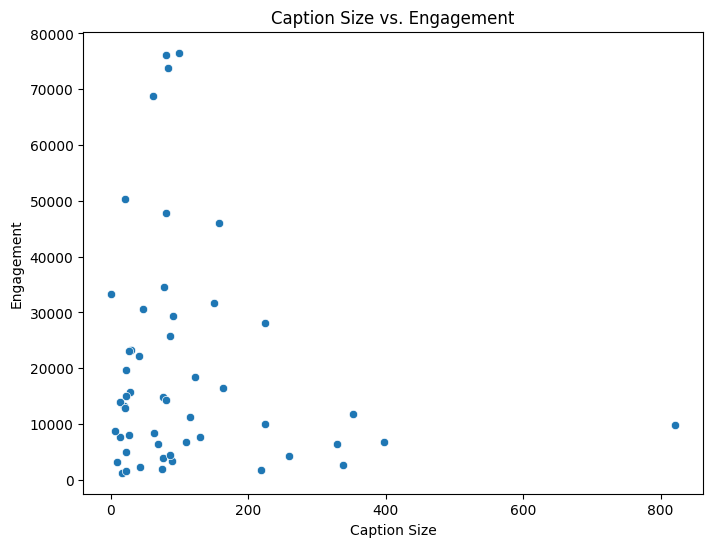

Correlation between caption size and engagement: -0.13802860173799159


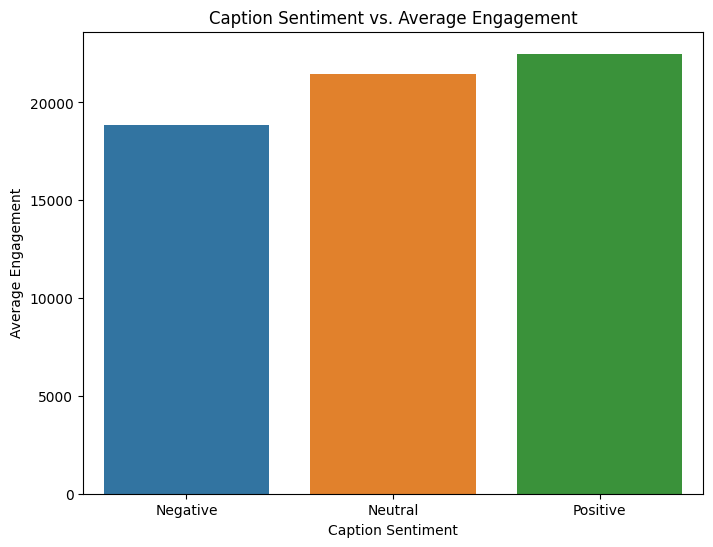

ANOVA p-value: 0.32915177074475443


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# tamanho da caption x engajamento
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="caption_length", y="total_interactions")
plt.xlabel("Caption Size")
plt.ylabel("Engagement")
plt.title("Caption Size vs. Engagement")
plt.show()

# calcula a correlação entre tamanho da caption e engajamento
correlation, p_value = pearsonr(df["caption_length"], df["total_interactions"])
print("Correlation between caption size and engagement:", correlation)

# sentimento da caption x engajamento
sentiment_mapping = {"positive": 1, "neutral": 0, "negative": -1}
df["sentiment_numeric"] = df["caption_sentiment"].map(sentiment_mapping)

sentiment_engagement = df.groupby("sentiment_numeric")["total_interactions"].mean()

# plota o gráfico
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_engagement.index, y=sentiment_engagement.values)
plt.xlabel("Caption Sentiment")
plt.ylabel("Average Engagement")
plt.title("Caption Sentiment vs. Average Engagement")
plt.xticks(ticks=np.arange(3), labels=["Negative", "Neutral", "Positive"])
plt.show()

# faz teste estatístico (e.g., ANOVA)
sentiment_groups = [
    df.loc[df["sentiment_numeric"] == -1, "total_interactions"],
    df.loc[df["sentiment_numeric"] == 0, "total_interactions"],
    df.loc[df["sentiment_numeric"] == 1, "total_interactions"]
]

print("ANOVA p-value:", p_value)

In [ ]:
sentiment_order = ['highly_positive', 'positive', 'neutral', 'negative', 'highly_negative']

# converte os dicionários comment_scores em séries Pandas
comment_sentiments = df['comment_scores'].apply(lambda x: max(x, key=x.get))
comment_counts = pd.Series(comment_sentiments).value_counts()

# reindexa para ordenar o sentimentoem categorias e preenche o resto com 0
comment_counts_ordered = comment_counts.reindex(sentiment_order, fill_value=0)

print(comment_counts_ordered)

highly_positive    15
positive            1
neutral            19
negative            0
highly_negative    17
Name: comment_scores, dtype: int64


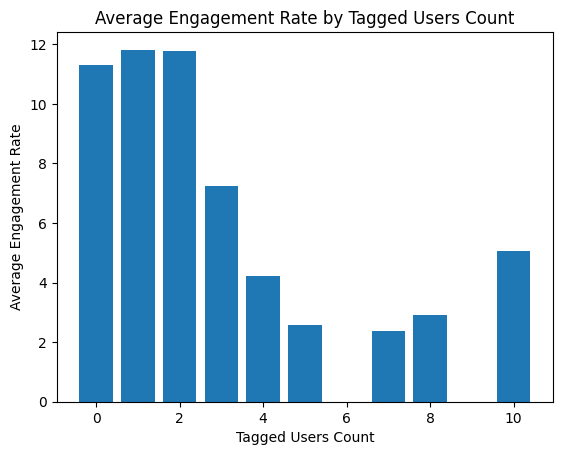

In [ ]:
correlation = df['tagged_users_count'].corr(df['engagement_rate'])

# plota os dados como bar plot
plt.bar(df['tagged_users_count'], df['engagement_rate'])
plt.xlabel('Tagged Users Count')
plt.ylabel('Average Engagement Rate')
plt.title('Average Engagement Rate by Tagged Users Count')

plt.show()